<a href="https://colab.research.google.com/github/yjodev/Tobigs19/blob/main/week3_NeuralNetworkBasic_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # Neural Network Basic - Week3 과제


## Import Library

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = '/content/gdrive/My Drive/투빅스/과제/W3_NNBasic_과제/'

In [ ]:
import sys, os
sys.path.append(data_path)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from dataset.mnist import load_mnist

## Load Dataset
- MNIST 

In [ ]:
(X_train, Y_train), (X_test, Y_test) = \
    load_mnist(normalize=True, one_hot_label=False)

In [ ]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_train shape: {Y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## Activation Function 
- sigmoid & relu : hidden layer activation function 
- softmax : output layer activation function 

In [ ]:
class sigmoid:
    # sigmoid 함수를 작성하세요 
    def forward(x):
        return 1 / (1+np.exp(-x))
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(x): # x는 역전파 계산시 입력된 값 
        return x * (1 - x) # 시그모이드 function를 미분

In [ ]:
class relu:
    # relu 함수를 작성하세요
    def forward(x):
        return np.maximum(0, x) # 0 이하의 값은 0, 0 이상의 값은 그 값을 리턴
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
        return np.where(x > 0, 1, 0) # 0 이하의 값은 0, 0 이상의 값은 1의 gradient

In [ ]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

## Loss Function

In [ ]:
def cross_entropy(p, y): # MSE가 아닌 또다른 Loss function
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) 
    return loss

## Layer

In [ ]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [ ]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200):
        self.lr = lr # Gradient descent 학습률
        self.epoch = epoch # 데이터셋 전체를 반복하여 학습할 횟수
        self.batch_size = batch_size 
        # 데이터를 하나씩 학습하는 것이 아니라, 배치별로 행을 이루는 행렬을 만들어 학습하기 위함
        # 배치 사이즈 = 행의 갯수
        self.loss_function = cross_entropy # 모델의 성능은 Loss function의 값이 작을수록 좋다
        self.layers = [] # Layer을 빈 배열로 초기화
        self.activations = [softmax] # 활성화함수는 softmax를 사용한다
        self.nodes = [] # Node를 빈 배열로 초기화
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer) # 입력받은 Layer를 빈 Layer list 에 추가한다
        if not self.nodes: # node가 비어있다 = 처음 입력
            self.nodes.append(np.zeros(Layer.input_size)) # input size와 같은 형태이고, 값이 0으로 채워진 행렬을 nodes에 추가한다
        self.nodes.append(np.zeros(Layer.output_size)) # 첫 입력이 아닌 경우, output size와 같은 형태이고, 값이 0으로 채워진 행렬을 nodes에 추가한다.
        
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation):
        tmp = self.activations.pop() # 가장 마지막 활성화 함수인 확률벡터를 리턴하는 softmax함수를 임시 변수로 추출한다.
        self.activations.append(Activation) # 새로운 활성함수 추가
        self.activations.append(tmp)  # 마지막 활성화 함수는 softmax함수가 되도록 앞서 저장한 tmp를 다시 append
        
    # 순전파 함수
    def _forward(self, X): # X: 입력데이터
        self.nodes[0] = X.copy() # 첫번째 노드값은 입력받은 X값이다. 이때, x.copy를 사용해서 추후 X값이 변하지 않도록 한다.
        output = X.copy() # output값에도 입력값을 copy하여 넣는다.
        for i in range(len(self.layers)): # layer수만큼 반복
            Layer = self.layers[i] # i번째 layer
            Activation = self.activations[i] #i번째 활성화함수
            output = np.dot(self.nodes[i], Layer.weight) #i번째 노드와 weight행렬을 곱한다
            output = output+ Layer.bias # 앞서 구한값에에 bias를 더하여 아파인계산
            output = Activation.forward(output) #아파인계산값을 활성화함수에 입력
            self.nodes[i+1] = output # 결과값을 새로운 node값으로 설정
        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))): # layer수만큼, 반대 순서로 반복
            a = self.nodes[i+1] # 레이어+1의 노드값(활성화함수 적용 결과)을 a라고 하자.
            Layer = self.layers[i] # 레이어의 인덱스는 그대로 사용
            Activation = self.activations[i] # 활성화함수의 인덱스도 그대로 사용
            
            if i+1 == len(self.layers): # i+1 = layer수
                error = Activation.backward(output, y) # error 계산
            else:
                error *= Activation.backward(a)
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0]  # i번째 layer 업데이트
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0] # i번째 bias 업데이트
            error = np.dot(error, Layer.weight.T) # error 계산
            
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1) # softmax 함수값(확률)이 가장 큰 인덱스
        return np.sum(pre_p==y)/y.shape[0] # 분류가 올바른 비율
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []}
        N = X.shape[0]
        for i in range(self.epoch): # epoch = 데이터 전체를 몇 번 반복학습할 것인가
            for j in range(N//self.batch_size): # 전체 데이터를 미니배치개수로 나누어 실행
                batch_mask = np.random.choice(N, self.batch_size) # 미니배치는 랜덤반복추출
                X_batch = X[batch_mask] # X배치 추출
                y_batch = y[batch_mask] # y배치 추출
                output = self._forward(X_batch) # 순전파
                self._backward(X_batch, output, y_batch) # 역전파
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X) # 순전파 결과
            history["val_acc"].append(self._accuracy(output, val_y)) # 앞서 정의한 Accuracy 계산함수를 사용하여 에포크별로 정확도 기록
            history["val_loss"].append(sum(self.loss_function(output, val_y))) # Loss function(cross entropy)값도 에포크별로 기록
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 10 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

In [ ]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.005, epoch=200, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100)) # 첫 레이어
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [ ]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [ ]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1135
0 test loss     : 23132.0037483293
10 test accuracy : 0.1914
10 test loss     : 22865.459884263593
20 test accuracy : 0.2106
20 test loss     : 22662.441576524594
30 test accuracy : 0.2109
30 test loss     : 22202.023739140226
40 test accuracy : 0.2504
40 test loss     : 21184.333689231004
50 test accuracy : 0.3055
50 test loss     : 19729.875109831835
60 test accuracy : 0.3796
60 test loss     : 18305.127177092454
70 test accuracy : 0.4584
70 test loss     : 16684.98562143541
80 test accuracy : 0.5387
80 test loss     : 14670.512611571065
90 test accuracy : 0.5969
90 test loss     : 13014.475355552911
100 test accuracy : 0.651
100 test loss     : 11601.318914569885
110 test accuracy : 0.6985
110 test loss     : 10284.824992345686
120 test accuracy : 0.7334
120 test loss     : 9200.172043939932
130 test accuracy : 0.7682
130 test loss     : 8329.726416779175
140 test accuracy : 0.7904
140 test loss     : 7609.561157349337
150 test accuracy : 0.8129
150 test los

## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

In [25]:
# 함수화 하기
def plot_accuracy_loss(history, epoch):
    fig = plt.figure()
    ax_acc = fig.add_subplot(111)

    # 에포크 숫자만큼 range(epoch)를 변경
    ax_acc.plot(range(epoch), history['val_acc'], label='정확도(%)', color='darkred')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy(%)')
    ax_acc.grid(linestyle='--', color='lavender')
    ax_loss = ax_acc.twinx()
    ax_loss.plot(range(epoch), history['val_loss'], label='오차', color='darkblue')
    plt.ylabel('Loss')
    ax_loss.yaxis.tick_right()
    ax_loss.grid(linestyle='--', color='lavender')

    # 그래프 표시
    plt.show()

    # 최고 accuracy는?
    print("Best Accuracy : ",max(history['val_acc']))


    # 최소 loss function값은?
    print("Lowest Loss : ",min(history['val_loss']))
    

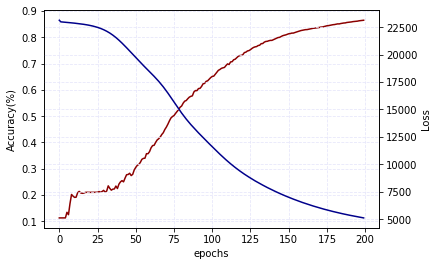

Best Accuracy :  0.8643
Lowest Loss :  5112.755683579848


In [26]:
plot_accuracy_loss(history, 200)